# Clustering Analysis via Regression
In this notebook, we analyze the clustering conducted in `clustering.ipynb` to get a better idea of walkability and bikeability discomfort. To conduct this, we do the following:
1. Change cluster labels to reflect rankings.
2. Apply linear regression to both bikeability and walkability datasets, with the `rank` column as the target variable.
3. Determine the weights of the linear regression models.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [38]:
gdf_edge_bike = gpd.read_file('geofabrik_merged_data (tentative)/geofabrik_bike_graph_edges_w_EDSAaccidents.geojson')
gdf_edge_walk = gpd.read_file('geofabrik_merged_data (tentative)/geofabrik_walk_graph_edges_w_EDSAaccidents.geojson') 
df_bike = pd.read_csv('features/bike_cluster_full.csv')
df_walk = pd.read_csv('features/walk_cluster_full.csv')

# Reflecting rankings
(Copied from ranking analysis document)
**Hierarchy was based on weights of components in [Arellana et. al 2020](https://www.sciencedirect.com/science/article/abs/pii/S0965856420306534)**
1. Compared first on cycling_lane_coverage (security)
2. Obstruction_density (convenience)
3. Highway category (directness and coherence)
the more primary/secondary/tertiary roads, the better. Worse if more residential roads 
4. Greenery coverage

### Important caveat: This is a proof of concept. 
- Better if they use real survey data to fit the regression model
- The ranking is incredibly crude. I did a series of sequential filters but obviously bikeability doesn’t work like that.
- Example: the ranking of cluster 3 fell all the way to 8th because it was mostly residential. But that it is residential may not matter to a recreational biker. 


In [44]:
bikeability_ranking = {
    4:1,
    1:2,
    8:3,
    2:4,
    0:5,
    5:6,
    7:7,
    3:8,
    6:9
}

walkability_ranking = {
    6:1,
    3:2,
    2:3,
    5:4,
    7:5,
    0:6,
    8:7,
    1:8,
    4:9
}

In [45]:
df_bike['rank'] = df_bike['Cluster'].replace(bikeability_ranking)
df_walk['rank'] = df_walk['Cluster'].replace(walkability_ranking)

In [46]:
df_bike_geo = df_bike.merge(gdf_edge_bike, how='inner', on=['u','v','key']).reset_index()
df_walk_geo = df_walk.merge(gdf_edge_walk, how='inner', on=['u','v','key']).reset_index()

In [47]:
gdf_bike = gpd.GeoDataFrame(df_bike_geo)
gdf_walk = gpd.GeoDataFrame(df_walk_geo)

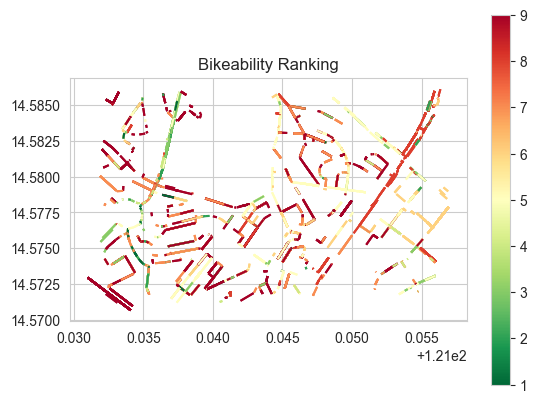

In [63]:
sns.set_style("whitegrid")
sns.set_palette("muted")

gdf_bike.plot(
    column='rank', 
    legend=True, 
    cmap='RdYlGn_r')

plt.title('Bikeability Ranking')
plt.savefig('bikeability_ranking.jpg')
plt.show()

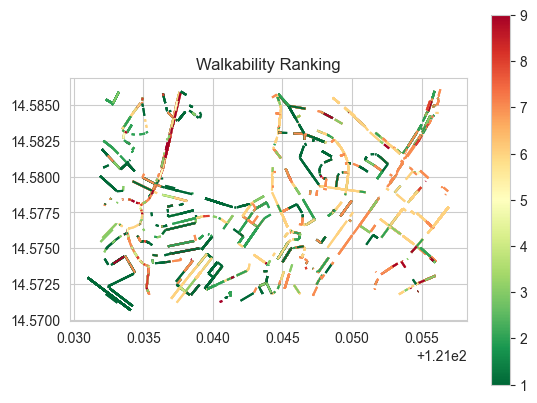

In [64]:
gdf_walk.plot(
    column='rank', 
    legend=True, 
    cmap='RdYlGn_r')

plt.title('Walkability Ranking')
plt.savefig('walkability_ranking.jpg')
plt.show()

# Applying Linear Regression

In [65]:
# Numerical variables are already scaled
cat_vars = 'scene_label highway surface'.split(' ')

In [66]:
# One-Hot Encoding for categorical columns, and scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_vars) 
    ], 
    remainder='passthrough'
)

# Step 2: Pipeline
def perform_linear_regression(df, target_col):
    # Ensure X remains a DataFrame for column operations
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Define the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('linear_regression', LinearRegression())
    ])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    # Get the coefficients/weights and intercept
    weights = pipeline.named_steps['linear_regression'].coef_
    intercept = pipeline.named_steps['linear_regression'].intercept_

    # Get feature names after encoding to match coefficients
    encoded_feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
    
    # Create a summary of weights
    coef_summary = pd.DataFrame({
        'Feature': encoded_feature_names,
        'Coefficient': weights
    })
    coef_summary.sort_values('Coefficient', ascending=False, inplace=True)

    return coef_summary, intercept, pipeline

In [67]:
X_bike = df_bike.drop(columns=['u','v','key'])
X_walk = df_walk.drop(columns=['u','v','key'])

In [68]:
coef_bike, intercept_bike, pipeline_bike = perform_linear_regression(X_bike, 'rank')
coef_walk, intercept_walk, pipeline_walk = perform_linear_regression(X_walk, 'rank')

In [71]:
coef_bike

,Feature,Coefficient
18,cat__highway_trunk_link,1.175106e+11
17,cat__highway_trunk,1.175106e+11
10,cat__highway_path,1.175106e+11
9,cat__highway_footway,1.175106e+11
19,cat__highway_unclassified,1.175106e+11
13,cat__highway_residential,1.175106e+11
11,cat__highway_pedestrian,1.175106e+11
14,cat__highway_secondary,1.175106e+11
16,cat__highway_tertiary,1.175106e+11
12,cat__highway_primary,1.175106e+11


In [72]:
coef_walk

,Feature,Coefficient
4,cat__scene_label_forest_road,3.090048e+12
6,cat__scene_label_railroad_track,3.090048e+12
3,cat__scene_label_driveway,3.090048e+12
1,cat__scene_label_bridge,3.090048e+12
2,cat__scene_label_crosswalk,3.090048e+12
5,cat__scene_label_highway,3.090048e+12
7,cat__scene_label_residential_neighborhood,3.090048e+12
8,cat__scene_label_street,3.090048e+12
0,cat__scene_label_alley,3.090048e+12
31,remainder__sidewalk_ratio,1.666756e+00
